# Programming Assignment: Classification and Visual Search

Congratulations on reaching the assignment of this module! You've journeyed through the concepts of custom architectures, exploring how designs like ResNet use skip connections for deeper training, DenseNet maximizes feature reuse through concatenation, and Siamese Networks learn powerful similarity functions. You've also seen the fundamental importance of **modular design**, building reusable `nn.Module` components, to manage complexity and enable flexibility.

Now, it's time to put all these principles into practice in a real-world scenario. Step into the role of an AI engineer at a leading online fashion retailer. Your task is to build the core AI engine for an intelligent product catalog system. This involves creating two distinct but related capabilities: accurately **classifying** clothing items and powering a **visual search** engine for recommendations.

This assignment challenges you to think like a professional engineer, focusing on **efficiency** and **reusability**. You won't just build models; you'll architect them using custom, modular blocks inspired by modern efficient networks. You'll see how a well-designed feature extractor can be leveraged for multiple downstream tasks, a common and powerful pattern in applied deep learning.

Throughout this programming assignment, you will:

* Implement the `InvertedResidualBlock`, the efficient core component inspired by MobileNetV2, practicing custom module creation.
* Construct a `MobileNetBackbone` by stacking your custom blocks, demonstrating modular network assembly.
* Build and train a `MobileNetLikeClassifier` using the backbone for multi-class fashion item categorization, applying techniques like weighted loss for imbalance.
* Design a `TripleDataset` to generate anchor, positive, and negative examples, setting the stage for similarity learning.
* Engineer a `SiameseEncoder` by **reusing** the trained backbone from your classifier, showcasing architectural flexibility.
* Assemble and train a `SiameseNetwork` using `TripletMarginLoss` to create a meaningful embedding space for visual similarity.
* Apply your trained Siamese network to perform visual search, retrieving similar fashion items from a catalog based on image embeddings.

Let's start building this intelligent fashion catalog engine!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents
- [Imports](#0)
- [1 - Building a Fashion Item Classifier](#1)
    - [1.1 - The Fashion Dataset: A Curated View](#1-1)
    - [1.2 - Preparing the Data Pipeline](#1-2)
    - [1.3 - Architecting the Classifier: Efficiency with Inverted Residuals](#1-3)
        - **[Exercise 1 - InvertedResidualBlock](#ex-1)**  
        - **[Exercise 2 - MobileNetBackbone](#ex-2)**
    - [1.4 - Assembling the Full Classifier](#1-4)
    - [1.5 - Training the Classifier](#1-5)  
    - [1.6 - Evaluating the Classifier](#1-6)
- [2 - Building a Visual Search Engine](#2)
    - [2.1 - Powering Recommendations with Similarity Learning](#2-1)
    - [2.2 - Teaching Similarity: The Triplet Dataset](#2-2)
        - **[Exercise 3 - TripleDataset](#ex-3)**
    - [2.3 - Architecting the Visual Search Model](#2-3)
        - [2.3.1 - The Siamese Encoder: Reusing the Backbone](#2-3-1)
        - [2.3.2 - The Siamese Network Wrapper](#2-3-2)
    - [2.4 - Training the Siamese Network](#2-4)
    - [2.5 - Performing Visual Search (Retrieval)](#2-5)

<a name='0'></a>
## Imports

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset
import unittests

In [37]:
import torch
import torchvision.utils as vutils
from IPython.display import display
from torchvision import transforms
import torchinfo
import copy

In [38]:
import helper_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1 - Building a Fashion Item Classifier

Your first task as an AI engineer for the online fashion retailer is to build a model that can accurately categorize clothing items. This is a fundamental step for organizing the product catalog and enabling features like filtered search. You'll start by constructing a model inspired by the efficient **MobileNet architecture**, known for its performance on devices with limited computational resources, a valuable trait for potential deployment in mobile apps or embedded systems.

<a name='1-1'></a>
### 1.1 - The Fashion Dataset: A Curated View

You'll be working with image data derived from the **clothing-dataset-small** collection, originally found [here](https://github.com/alexeygrigorev/clothing-dataset-small). For this assignment, a specific subset has been curated and organized into training and validation sets, focusing on the following distinct clothing categories: `dress`, `hat`, `longsleeve`, `pants`, `shoes`, `shorts`, and `t-shirt`.

This curated dataset presents a realistic scenario where you need to build a robust model from a moderately sized collection of images.

<a name='1-2'></a>
### 1.2 - Preparing the Data Pipeline

Before you can train your classifier, you need a solid data pipeline. This involves defining how images are transformed (resized, augmented, normalized) and how they are loaded in batches. You'll set up separate transformation pipelines for training (including augmentation to help the model generalize) and validation (only essential preprocessing).

* First, define the image transformation pipelines for your training and validation datasets. The training pipeline includes augmentations like random flips and rotations to make your model more robust, while the validation pipeline only applies the necessary resizing and normalization.

In [39]:
# Compose the transformations for training: resize, augment, then preprocess
train_transform = transforms.Compose([
    # Resize images to a consistent square size (64x64 pixels)
    transforms.Resize((64, 64)),
    # Apply random horizontal flipping for data augmentation
    transforms.RandomHorizontalFlip(),
    # Apply random rotation (up to 10 degrees) for data augmentation
    transforms.RandomRotation(10),
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize tensor values to range [-1, 1] (using mean=0.5, std=0.5)
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])


# For validation: only resize and preprocess (no augmentation)
val_transform = transforms.Compose([
    # Resize images to the same consistent square size (64x64 pixels)
    transforms.Resize((64, 64)),
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize tensor values to range [-1, 1] (using mean=0.5, std=0.5)
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])

* Specify the location of the dataset.

In [40]:
# Define the path to the root directory containing the dataset
dataset_path = "./clothing-dataset-small"

* Now, load the training and validation datasets using the `load_datasets` helper function, applying the appropriate transformations you just defined.

In [41]:
# Load the training and validation datasets
train_dataset, validation_dataset = helper_utils.load_datasets(
    # Path to the dataset directory
    dataset_path=dataset_path,
    # Apply the defined training transformations
    train_transform=train_transform,
    # Apply the defined validation transformations
    val_transform=val_transform,
    )

* Extract the class names directly from the loaded training dataset and determine the total number of classes your model will need to predict.

In [42]:
# Get the list of class names automatically inferred from the folder structure
classes = train_dataset.classes

# Get the total number of classes
num_classes = len(classes)

# Print the discovered class names
print(f"Classes: {classes}")
# Print the total count of classes
print(f"Number of classes: {num_classes}")

Classes: ['dress', 'hat', 'longsleeve', 'pants', 'shoes', 'shorts', 't-shirt']
Number of classes: 7


* It's always a good practice to visualize your data. Run the cell below to see a sample of images from the training set along with their corresponding labels.

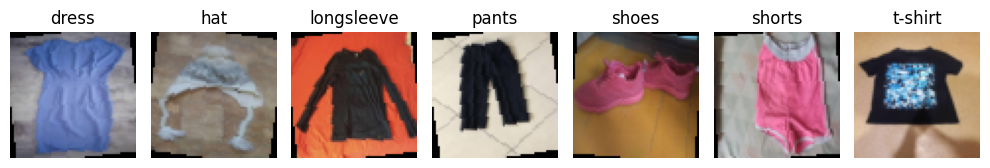

In [43]:
# Display a grid of sample images from the training dataset with their labels
helper_utils.show_sample_images(train_dataset)

* Finally, create the `DataLoader` instances for both training and validation sets. These will handle shuffling the training data and organizing the images into batches for efficient processing during model training.

In [44]:
# Create DataLoaders for managing batching and shuffling
train_loader, val_loader = helper_utils.create_dataloaders(
    # Pass the training dataset
    train_dataset=train_dataset,
    # Pass the validation dataset
    validation_dataset=validation_dataset,
    # Define the number of images per batch
    batch_size=32
)

<a name='1-3'></a>
### 1.3 - Architecting the Classifier: Efficiency with Inverted Residuals

With your data pipeline ready, it's time to design the engine that will learn to classify the fashion items. For the online retailer, efficiency is key. The model might eventually run on various devices, possibly even directly within a mobile app. This calls for an architecture that balances accuracy with computational cost.

You'll build a classifier inspired by **MobileNetV2**, a highly successful architecture known for its performance on resource constrained devices. The core innovation you'll implement is the **Inverted Residual Block**.

Unlike the residual blocks you might have seen in ResNet (which typically have a wide -> narrow -> wide structure in terms of channels), the inverted residual block uses a narrow -> wide -> narrow approach. It first expands the input channels using a computationally inexpensive 1x1 convolution, then applies a lightweight **depthwise separable convolution** for spatial feature extraction in the expanded space, and finally projects the features back down to a lower dimension with another 1x1 convolution. A skip connection, similar to ResNet, is also used to help with gradient flow. This design significantly reduces the number of parameters and computations compared to standard convolutional blocks, making the model faster and more memory efficient.

You'll construct this classifier modularly:
1.  First, you'll build the `InvertedResidualBlock` itself.
2.  Then, you'll stack these blocks to create a `MobileNetBackbone`.
3.  Finally, you'll add a simple classification `head` to the backbone to get the final `MobileNetLikeClassifier`.

This modular approach makes your code cleaner, easier to debug, and highly reusable principles you've seen emphasized throughout your learning journey. Let's start building the fundamental block.

<a name='ex-1'></a>
### Exercise 1 - InvertedResidualBlock

Your first exercise is to implement the `InvertedResidualBlock`. This block forms the heart of your efficient classifier. You need to define the layers in the `__init__` method and specify how data flows through them in the `forward` method.

**Your Task**:

**Inside the `__init__` method**:
> * **Expansion Layer (`self.expand`)**: Define an `nn.Sequential` block. This block needs to first expand the channels using a 1x1 convolution, then apply batch normalization, and finally use a ReLU activation.
>
> * **Projection Layer (`self.project`)**: Define another `nn.Sequential` block. This one will project the channels back down. It needs a 1x1 convolution (this time without a following activation) and a batch normalization layer.

**Inside the `forward` method**:

> * **Save the Skip Connection**: Before doing anything, you must save a reference to the input tensor `x`. This will be used for the residual connection.
>
> * Define the Main Path**: Pass the input `x` sequentially through your `self.expand`, `self.depthwise`, and `self.project` layers.
>
> * **Apply the Shortcut**: Inside the `if self.shortcut is not None:` block, you need to process the *original* input `x` (which you saved) through the `self.shortcut` module.
>
> * **Add the Residual**: After the `if` block, add your saved (and potentially processed) `skip` tensor to the output of the main path (`out`).

<details> <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you find yourself stuck, here is a more detailed breakdown.

**For the `__init__` method**:

* `self.expand`: You are building an `nn.Sequential`.
    * The first layer is an `nn.Conv2d`. You need to set its `in_channels` to `in_channels`, `out_channels` to `hidden_dim`, and `kernel_size` to `1`. Remember to set `bias=False`.
    * The second layer is `nn.BatchNorm2d`. You just need to pass the number of features, which is `hidden_dim`.
    * The third layer is `nn.ReLU(inplace=True)`.
>
* `self.project`: This is another `nn.Sequential`.
    * The first layer is an `nn.Conv2d`. This one goes from `hidden_dim` to `out_channels` with a `kernel_size` of `1` and `bias=False`.
    * The second layer is `nn.BatchNorm2d`, and its number of features should match the output, so it's `out_channels`.

**For the forward method**:

* **Saving the skip**: `skip = x`
>
* **Main path**: You just need to call the layers you defined: `out = self.expand(x)`
    * Follow this pattern to call `self.depthwise` on the result (`out`), and then `self.project` on that result.
>
* **Applying the shortcut**: Inside the `if` block, you need to update the skip variable: `skip = apply self.shortcut to the original input x`
>
* **Adding the residual**: This is a simple tensor addition: `out = out + skip (or use +=)`

</details>

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InvertedResidualBlock(nn.Module):
    """
    Implements an inverted residual block, often used in architectures like MobileNetV2.
    """
    
    def __init__(self, in_channels, out_channels, stride, expansion_factor, shortcut=None):
        super().__init__()
        hidden_dim = in_channels * expansion_factor

        # Expansion phase: 1x1 conv -> BN -> ReLU
        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
        ) 

        # Depthwise convolution is already defined
        self.depthwise = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=stride,
                padding=1,
                groups=hidden_dim,  # depthwise
                bias=False,
            ),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
        )

        # Projection phase: 1x1 conv (linear) -> BN
        self.project = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ) 

        # Optional shortcut
        self.shortcut = shortcut

    def forward(self, x):
        # Save input for potential residual connection
        skip = x

        # Forward pass through the block
        out = self.expand(x)
        out = self.depthwise(out)
        out = self.project(out)

        # Apply shortcut if provided
        if self.shortcut is not None:
            skip = self.shortcut(x)

        # Add skip connection
        out = out + skip

        # Final ReLU
        return F.relu(out)


In [46]:
# --- Verification ---
# Define parameters for a sample block instance
batch_size=32
in_ch = 16 # Input channels
out_ch = 16 # Output channels (same for stride=1)
stride = 1
exp_factor = 3 # Expansion factor
img_size = 32 # Input image height/width

# Instantiate the block
block = InvertedResidualBlock(
    in_channels=in_ch,
    out_channels=out_ch,
    stride=stride,
    expansion_factor=exp_factor,
)

# Define the input tensor shape
input_size = (batch_size, in_ch, img_size, img_size)

# Configuration for torchinfo summary
config = {
    "input_size": input_size,
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": 3 # Show layers up to 3 levels deep
}

# Generate the summary
summary = torchinfo.summary(
    model=block,
    input_size=config["input_size"],
    col_names=config["attr_names"],
    depth=config["depth"]
)

# Display the formatted summary
print("--- Block Summary (Stride=1, Same Channels) ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Block Summary (Stride=1, Same Channels) ---



Layer (type (var_name):depth-idx),Input Shape,Output Shape,Param #
InvertedResidualBlock (InvertedResidualBlock),"[32, 16, 32, 32]","[32, 16, 32, 32]",--
Sequential (expand): 1-1,"[32, 16, 32, 32]","[32, 48, 32, 32]",--
Conv2d (0): 2-1,"[32, 16, 32, 32]","[32, 48, 32, 32]",768
BatchNorm2d (1): 2-2,"[32, 48, 32, 32]","[32, 48, 32, 32]",96
ReLU (2): 2-3,"[32, 48, 32, 32]","[32, 48, 32, 32]",--
Sequential (depthwise): 1-2,"[32, 48, 32, 32]","[32, 48, 32, 32]",--
Conv2d (0): 2-4,"[32, 48, 32, 32]","[32, 48, 32, 32]",432
BatchNorm2d (1): 2-5,"[32, 48, 32, 32]","[32, 48, 32, 32]",96
ReLU (2): 2-6,"[32, 48, 32, 32]","[32, 48, 32, 32]",--
Sequential (project): 1-3,"[32, 48, 32, 32]","[32, 16, 32, 32]",--


#### Expected Output:

<div style="float: left;">

| Layer (type (var_name):depth-idx) | Input Shape | Output Shape | Param # |
| :--- | :--- | :--- | :--- |
| InvertedResidualBlock (InvertedResidualBlock) | [32, 16, 32, 32] | [32, 16, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;Sequential (expand): 1-1 | [32, 16, 32, 32] | [32, 48, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2d (0): 2-1 | [32, 16, 32, 32] | [32, 48, 32, 32] | 768 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;BatchNorm2d (1): 2-2 | [32, 48, 32, 32] | [32, 48, 32, 32] | 96 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ReLU (2): 2-3 | [32, 48, 32, 32] | [32, 48, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;Sequential (depthwise): 1-2 | [32, 48, 32, 32] | [32, 48, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2d (0): 2-4 | [32, 48, 32, 32] | [32, 48, 32, 32] | 20,736 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;BatchNorm2d (1): 2-5 | [32, 48, 32, 32] | [32, 48, 32, 32] | 96 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ReLU (2): 2-6 | [32, 48, 32, 32] | [32, 48, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;Sequential (project): 1-3 | [32, 48, 32, 32] | [32, 16, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2d (0): 2-7 | [32, 48, 32, 32] | [32, 16, 32, 32] | 768 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;BatchNorm2d (1): 2-8 | [32, 16, 32, 32] | [32, 16, 32, 32] | 32 |

</div>
<div style="clear: both;"></div>

---
**Total params:** 22,496  
**Trainable params:** 22,496  
**Non-trainable params:** 0  
**Total mult-adds:** 0.73 GB  

---
**Input size (MB):** 2.00  
**Forward/backward pass size (MB):** 56.00  
**Params size (MB):** 0.09  
**Estimated Total Size (MB):** 58.09

In [47]:
# Test your code!
unittests.exercise_1(InvertedResidualBlock)

 All tests passed!


<a name='ex-2'></a>
### Exercise 2 - MobileNetBackbone

Now that you have a working `InvertedResidualBlock`, you'll assemble the main feature extractor, the `MobileNetBackbone`. This involves creating an initial "stem" layer to process the input image and then stacking several `InvertedResidualBlock` instances using a helper method.

**Your Task**:

**Inside the `__init__` method**:
> * You must define the `self.blocks` sequential layer.
> * You will do this by calling the `self._make_block` helper function three times, once for each block in the sequence:
>
>    * The first block: `in_channels=16`, `out_channels=24`, `stride=2`, `expansion_factor=3`.
>    * The second block: `in_channels=24`, `out_channels=32`, `stride=2`, `expansion_factor=3`.
>    * The third block: `in_channels=32`, `out_channels=64`, `stride=2`, `expansion_factor=6`.

**Inside the `_make_block` method**:
> * **Shortcut Logic**: First, you must define the boolean `condition` that determines if a shortcut connection is needed. A shortcut is necessary if the input and output dimensions are different, which happens if the `stride` is not 1 OR if the `in_channels` and `out_channels` do not match.
>
> * **Block Instantiation**: At the end of the method, you must create and return an instance of the `InvertedResidualBlock` (which you built in the previous exercise). You have all the required parameters available as arguments to the `_make_block` function.

<details> <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you find yourself stuck, here is a more detailed breakdown.

**For the `__init__` method**:

* You are filling in the `nn.Sequential` for `self.blocks`.
* The first line will be `self._make_block(16, 24, stride=2, expansion_factor=3),`
* You should follow this exact pattern for the next two blocks, using the parameters specified in the instructions for each line.

**For the `_make_block` method**:

* **Defining the condition**: You need to write a boolean expression that checks for two things.
    > `condition = (check if in_channels is not equal to out_channels) or (check if stride is not equal to 1)`

* **Instantiating the `block`**:
    * You are just calling the constructor for the `InvertedResidualBlock` class.
    * You need to pass all five arguments that `_make_block` received:
    > `block = create a new InvertedResidualBlock(using in_channels, out_channels, stride, expansion_factor, and shortcut)`

</details>

In [48]:
import torch
import torch.nn as nn

class MobileNetBackbone(nn.Module):
    """
    Implements a simplified MobileNet-like backbone feature extractor.
    """

    def __init__(self):
        super().__init__()
        # Initial stem convolution
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        # Define the main stack of inverted residual blocks
        self.blocks = nn.Sequential(
            self._make_block(16, 24, stride=2, expansion_factor=6),  # First block
            self._make_block(24, 32, stride=2, expansion_factor=6),  # Second block
            self._make_block(32, 64, stride=2, expansion_factor=6),  # Third block
        )

    def _make_block(self, in_channels, out_channels, stride=1, expansion_factor=6):
        """
        Helper method to create a single InvertedResidualBlock.
        """
        # Shortcut is needed if input/output channels differ or stride > 1
        condition = (in_channels != out_channels) or (stride != 1)
        if condition:
            shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            shortcut = None

        # Instantiate the InvertedResidualBlock
        block = InvertedResidualBlock(
            in_channels, out_channels, stride, expansion_factor, shortcut
        )
        return block

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        return x


In [49]:
# --- Verification ---
# Define parameters for verification
batch_size=32
img_size = 64 # Input image height/width
depth = 3 # Summary depth

# Instantiate the backbone
backbone = MobileNetBackbone()

# Define the input tensor shape
input_size = (batch_size, 3, img_size, img_size)

# Configuration for torchinfo summary
config = {
    "input_size": input_size,
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": depth
}

# Generate the summary
summary = torchinfo.summary(
    model=backbone,
    input_size=config["input_size"],
    col_names=config["attr_names"],
    depth=config["depth"]
)

# Display the formatted summary
print("--- Backbone Summary ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Backbone Summary ---



Layer (type (var_name):depth-idx),Input Shape,Output Shape,Param #
MobileNetBackbone (MobileNetBackbone),"[32, 3, 64, 64]","[32, 64, 4, 4]",--
Sequential (stem): 1-1,"[32, 3, 64, 64]","[32, 16, 32, 32]",--
Conv2d (0): 2-1,"[32, 3, 64, 64]","[32, 16, 32, 32]",432
BatchNorm2d (1): 2-2,"[32, 16, 32, 32]","[32, 16, 32, 32]",32
ReLU (2): 2-3,"[32, 16, 32, 32]","[32, 16, 32, 32]",--
Sequential (blocks): 1-2,"[32, 16, 32, 32]","[32, 64, 4, 4]",--
InvertedResidualBlock (0): 2-4,"[32, 16, 32, 32]","[32, 24, 16, 16]",--
Sequential (expand): 3-1,"[32, 16, 32, 32]","[32, 96, 32, 32]","1,728"
Sequential (depthwise): 3-2,"[32, 96, 32, 32]","[32, 96, 16, 16]","1,056"
Sequential (project): 3-3,"[32, 96, 16, 16]","[32, 24, 16, 16]","2,352"


#### Expected Output:

<div style="float: left;">

| Layer (type (var_name):depth-idx) | Input Shape | Output Shape | Param # |
| :--- | :--- | :--- | :--- |
| MobileNetBackbone (MobileNetBackbone) | [32, 3, 64, 64] | [32, 64, 4, 4] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;Sequential (stem): 1-1 | [32, 3, 64, 64] | [32, 16, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2d (0): 2-1 | [32, 3, 64, 64] | [32, 16, 32, 32] | 432 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;BatchNorm2d (1): 2-2 | [32, 16, 32, 32] | [32, 16, 32, 32] | 32 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ReLU (2): 2-3 | [32, 16, 32, 32] | [32, 16, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;Sequential (blocks): 1-2 | [32, 16, 32, 32] | [32, 64, 4, 4] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;InvertedResidualBlock (0): 2-4 | [32, 16, 32, 32] | [32, 24, 16, 16] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (expand): 3-1 | [32, 16, 32, 32] | [32, 48, 32, 32] | 864 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (depthwise): 3-2 | [32, 48, 32, 32] | [32, 48, 16, 16] | 20,832 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (project): 3-3 | [32, 48, 16, 16] | [32, 24, 16, 16] | 1,200 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (shortcut): 3-4 | [32, 16, 32, 32] | [32, 24, 16, 16] | 432 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;InvertedResidualBlock (1): 2-5 | [32, 24, 16, 16] | [32, 32, 8, 8] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (expand): 3-5 | [32, 24, 16, 16] | [32, 72, 16, 16] | 1,872 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (depthwise): 3-6 | [32, 72, 16, 16] | [32, 72, 8, 8] | 46,800 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (project): 3-7 | [32, 72, 8, 8] | [32, 32, 8, 8] | 2,368 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (shortcut): 3-8 | [32, 24, 16, 16] | [32, 32, 8, 8] | 832 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;InvertedResidualBlock (2): 2-6 | [32, 32, 8, 8] | [32, 64, 4, 4] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (expand): 3-9 | [32, 32, 8, 8] | [32, 192, 8, 8] | 6,528 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (depthwise): 3-10 | [32, 192, 8, 8] | [32, 192, 4, 4] | 332,160 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (project): 3-11 | [32, 192, 4, 4] | [32, 64, 4, 4] | 12,416 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sequential (shortcut): 3-12 | [32, 32, 8, 8] | [32, 64, 4, 4] | 2,176 |
    
</div>
<div style="clear: both;"></div>      

---
**Total params:** 428,944  
**Trainable params:** 428,944  
**Non-trainable params:** 0  
**Total mult-adds:** 0.53 GB  

---
**Input size (MB):** 1.50  
**Forward/backward pass size (MB):** 65.75  
**Params size (MB):** 1.64  
**Estimated Total Size (MB):** 68.89

In [50]:
# Test your code!
unittests.exercise_2(MobileNetBackbone)

 All tests passed!


<a name='1-4'></a>
### 1.4 - Assembling the Full Classifier

With the backbone complete, the final step is to assemble the full `MobileNetLikeClassifier`. This involves combining your `MobileNetBackbone` with a simple classification head. The head takes the feature map produced by the backbone, reduces its spatial dimensions using **Adaptive Average Pooling**, flattens the result into a vector, and finally uses a **Linear layer** to produce the raw output scores (logits) for each class.

This modular assembly highlights the power of separating feature extraction (backbone) from the final task specific layers (head), making it easy to adapt the backbone for different purposes later on.

* The `MobileNetLikeClassifier` class is provided below. Instantiate it, making sure to pass the correct `num_classes` for your dataset.

In [51]:
class MobileNetLikeClassifier(nn.Module):
    """
    A classifier model that combines a feature extraction
    backbone with a simple classification head.
    """
    
    def __init__(self, num_classes=10):
        """
        Initializes the classifier components.

        Args:
            num_classes (int): The number of output classes for the final
                               classification layer.
        """
        # Initialize the parent nn.Module
        super().__init__()

        # Backbone extracts features from input images
        self.backbone = MobileNetBackbone()

        # Head processes the features to produce class predictions
        self.head = nn.Sequential(
            # Reduce spatial dimensions to 1x1
            nn.AdaptiveAvgPool2d(1),
            # Flatten the features into a 1D vector
            nn.Flatten(),
            # Map the flattened features to the number of output classes
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        """
        Defines the forward pass of the classifier.

        Args:
            x: The input tensor (batch of images).

        Returns:
            torch.Tensor: The raw, unnormalized output scores (logits)
                          for each class.
        """
        # Pass the input through the feature extraction backbone
        x = self.backbone(x)
        # Pass the features through the classification head
        x = self.head(x)
        # Return the final output
        return x

* Instantiate the complete classifier model.

In [52]:
# Ensure num_classes matches the number of categories in your dataset
mobilenet_classifier = MobileNetLikeClassifier(num_classes=num_classes)

* Generate and display a summary of the complete `MobileNetLikeClassifier`. This final check ensures the backbone and head are connected correctly, and you can see the data flow from the input image to the final class logits.

In [53]:
# Define parameters for verification
batch_size=32
img_size = 64 # Input image height/width
depth = 3 # Summary depth

# Define the input tensor shape
input_size = (batch_size, 3, img_size, img_size)

# Configuration for torchinfo summary
config = {
    "input_size": input_size,
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": depth # Show layers up to 3 levels deep for detail
}

# Generate the summary for the complete classifier
summary = torchinfo.summary(
    model=mobilenet_classifier,
    input_size=config["input_size"],
    col_names=config["attr_names"],
    depth=config["depth"]
)

# Display the formatted summary
print("--- Classifier Summary ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Classifier Summary ---



Layer (type (var_name):depth-idx),Input Shape,Output Shape,Param #
MobileNetLikeClassifier (MobileNetLikeClassifier),"[32, 3, 64, 64]","[32, 7]",--
MobileNetBackbone (backbone): 1-1,"[32, 3, 64, 64]","[32, 64, 4, 4]",--
Sequential (stem): 2-1,"[32, 3, 64, 64]","[32, 16, 32, 32]",--
Conv2d (0): 3-1,"[32, 3, 64, 64]","[32, 16, 32, 32]",432
BatchNorm2d (1): 3-2,"[32, 16, 32, 32]","[32, 16, 32, 32]",32
ReLU (2): 3-3,"[32, 16, 32, 32]","[32, 16, 32, 32]",--
Sequential (blocks): 2-2,"[32, 16, 32, 32]","[32, 64, 4, 4]",--
InvertedResidualBlock (0): 3-4,"[32, 16, 32, 32]","[32, 24, 16, 16]","5,568"
InvertedResidualBlock (1): 3-5,"[32, 24, 16, 16]","[32, 32, 8, 8]","10,832"
InvertedResidualBlock (2): 3-6,"[32, 32, 8, 8]","[32, 64, 4, 4]","23,232"


<a name='1-5'></a>
### 1.5 - Training the Classifier

Your efficient `MobileNetLikeClassifier` is fully assembled! Now it's time to teach it how to distinguish between different fashion items. This involves setting up the essential components for the training process:

**Class Weights**: Real-world datasets are often imbalanced, meaning some classes have many more examples than others. Training directly on such data can bias the model towards the majority classes. To counteract this, you'll calculate **class weights**. These weights give more importance to under-represented classes during loss calculation, encouraging the model to learn them effectively.

**Loss Function**: Measures how far the model's predictions are from the true labels. `CrossEntropyLoss` is suitable for this multi-class classification task, and you'll configure it to use the calculated class weights.

**Optimizer**: Adjusts the model's weights based on the loss to improve performance. `Adam` is a popular and effective choice.

**Learning Rate Scheduler**: Dynamically adjusts the learning rate during training. A `StepLR` scheduler will decrease the learning rate periodically, which can help the model converge more effectively.

* First, calculate the class weights based on the distribution of samples in your training dataset. Then, define the weighted `CrossEntropyLoss` function.

In [54]:
# Calculate class weights to handle imbalance in the dataset
class_weights = helper_utils.compute_class_weights(train_dataset)

# Move the weights tensor to the correct device (e.g., 'cuda' or 'cpu')
class_weights = class_weights.to(device)

# Define the loss function for multi-class classification, incorporating the calculated class weights
loss_fcn = nn.CrossEntropyLoss(weight=class_weights)

# Print the calculated weights for verification
print("Calculated class weights:")
for i, weight in enumerate(class_weights):
    print(f"- Class '{classes[i]}': {weight:.4f}")

Calculated class weights:
- Class 'dress': 1.4713
- Class 'hat': 2.8827
- Class 'longsleeve': 0.7793
- Class 'pants': 0.7576
- Class 'shoes': 1.7908
- Class 'shorts': 1.7553
- Class 't-shirt': 0.4460


* Next, define the optimizer (`Adam`) and the learning rate scheduler (`StepLR`).

In [55]:
# Define the Adam optimizer, passing the model's parameters and initial learning rate
optimizer = torch.optim.Adam(mobilenet_classifier.parameters(), lr=0.01)

# Define a learning rate scheduler that reduces the LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Now you are ready to start the training loop. The `helper_utils.training_loop` function will handle iterating through the data, calculating loss (using your weighted loss function), backpropagating, and updating the model weights for a specified number of epochs.

* Set the number of epochs for this training run. Feel free to start with a small number (like 5) to see the process working, and increase it later for better performance if needed.

In [56]:
# EDITABLE CELL:

# Set the number of epochs for training
n_epochs = 5

* Launch the training process using the `training_loop` helper function. This will train your `mobilenet_classifier` and return the trained model.

In [57]:
# Start the training loop
trained_classifier =  helper_utils.training_loop(
    mobilenet_classifier, 
    train_loader, 
    val_loader, 
    loss_fcn, 
    optimizer, 
    scheduler, 
    device, 
    n_epochs=n_epochs
)

--- Starting Training ---


Epoch 1/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 1.7450, Train Acc: 0.3218 | Val Loss: 2.2835, Val Acc: 0.2353
    ^ New best model found!


Epoch 2/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 1.5582, Train Acc: 0.4057 | Val Loss: 1.6333, Val Acc: 0.3425
    ^ New best model found!


Epoch 3/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 1.4161, Train Acc: 0.4813 | Val Loss: 1.5743, Val Acc: 0.4017
    ^ New best model found!


Epoch 4/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 1.2913, Train Acc: 0.5204 | Val Loss: 1.3463, Val Acc: 0.5043
    ^ New best model found!


Epoch 5/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 1.2060, Train Acc: 0.5576 | Val Loss: 1.2856, Val Acc: 0.5616
    ^ New best model found!

--- Training Complete ---

Returning best model from epoch 5 with 0.5616 validation accuracy.


<a name='1-6'></a>
### 1.6 - Evaluating the Classifier

Excellent work! You've successfully trained your custom-built `MobileNetLikeClassifier`. You went through the entire process: designing a reusable block (`InvertedResidualBlock`), assembling a backbone (`MobileNetBackbone`) from those blocks, adding a classification head, and orchestrating the training loop with weighted loss.

Keep in mind that the primary goal of these exercises was to practice building models with **modular components** and understanding how custom architectures are constructed. Achieving extremely high accuracy often requires more extensive data preprocessing, augmentation, and longer training times than used here. The accuracy you see reflects the model learning from the provided data structure, but the real accomplishment is mastering the *construction* process itself.

* Now, let's visualize some predictions from your trained model. This gives you a qualitative sense of its performance. Remember, given the focus on architecture rather than extensive tuning, you might see some incorrect predictions, which is perfectly normal in the model development cycle.

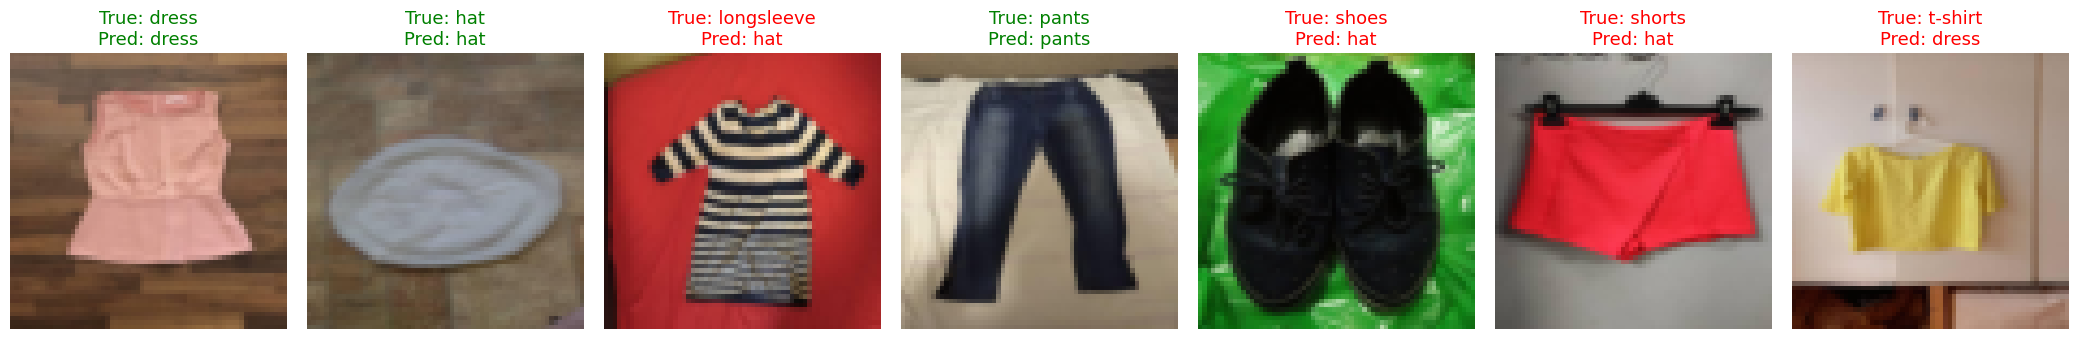

In [58]:
# Display predictions
helper_utils.display_random_predictions_per_class(trained_classifier, val_loader, classes, device)

<a name='2'></a>
## 2 - Building a Visual Search Engine

You've successfully built a classifier to categorize fashion items. Now, you'll tackle a different, equally important challenge for the online retailer: **visual search**. This feature allows customers to find products similar to an item they like, enhancing discoverability and potentially increasing sales.

<a name='2-1'></a>
### 2.1 - Powering Recommendations with Similarity Learning

Imagine a customer browsing your store finds a t-shirt they like. How can you instantly show them other t-shirts with a similar style, color, or pattern? Or, what if they upload a picture of a hat they saw elsewhere – how can you find the closest match in your inventory? Manually tagging and linking thousands of products is impractical.

This is where **similarity learning** and **Siamese Networks** shine. Instead of learning to classify items, a Siamese Network learns to map images into a special "embedding space" where visually similar items are located close together. By comparing the "distances" between items in this space, you can power several high impact features:

* **Visual Search ("Shop the Look"):** Allow customers to upload photos and find matching items in your catalog. (Only this is covered in this notebook later)
* **Smarter Recommendations ("You Might Also Like"):** Show relevant alternatives based on visual similarity to the currently viewed product.
* **Handling Out-of-Stock Items:** Suggest visually similar in stock alternatives when a product isn't available.

To build this system, you'll first need to prepare the data in a specific way that teaches the model the concept of similarity.

<a name='2-2'></a>
### 2.2 - Teaching Similarity: The Triplet Dataset

Unlike standard classification where the model learns from single images and labels, a Siamese Network learns from **comparisons**. To teach it which fashion items are visually similar (belonging to the same category, in this simplified case) and which are dissimilar, you need to provide examples in a specific format: **triplets**.

Each triplet consists of three images:
1.  **Anchor:** An image of a fashion item (e.g., a specific t-shirt).
2.  **Positive:** *Another* image from the **same category** as the anchor (e.g., a different t-shirt).
3.  **Negative:** An image from a **different category** than the anchor (e.g., a pair of pants).

By training on these triplets, the model learns to pull the anchor and positive embeddings closer together in the embedding space, while pushing the anchor and negative embeddings further apart. This process sculpts the embedding space, making it meaningful for visual search.

You'll create a custom PyTorch `Dataset` called `TripleDataset` that generates these triplets on the fly from your existing fashion dataset.

<a name='ex-3'></a>
### Exercise 3 - TripleDataset

Your task is to complete the `TripleDataset` class. It wraps your existing `train_dataset` and generates triplets dynamically. You need to implement the logic for selecting appropriate positive and negative examples for a given anchor image.

**Your Task**:

**Inside the `_get_positive_negative_indices` method**:

> * **Find Positive Index**: Get the list of all indices that match the `anchor_label`. From that list, select one random index. You should use the <code>[random.choice()](https://www.w3schools.com/python/ref_random_choice.asp)</code> function for this.
>
> * **Find Negative Index**: A random `negative_label` (different from the `anchor_label`) is already selected for you. You just need to get the list of all indices for that `negative_label` and select one random index from it, again using <code>[random.choice()](https://www.w3schools.com/python/ref_random_choice.asp)</code>.

**Inside the `__getitem__` method**:

> * **Get Anchor**: Get the `anchor_image` and `anchor_label` from `self.dataset` using the provided `idx`.
>
> * **Get Indices**: Call the `_get_positive_negative_indices` helper function, passing it the `anchor_label` to get the `positive_index` and `negative_index`.
>
> * **Get Positive & Negative Images**: Use the `positive_index` and `negative_index` you just received to get the corresponding `positive_image` and `negative_image` from `self.dataset`.

<details> <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you find yourself stuck, here is a more detailed breakdown.

**For the `_get_positive_negative_indices` method**:

* **Positive**:
    * First, get the list: `positive_indices = self.labels_to_indices[anchor_label]`
    * Then, pick one: `positive_index = use random.choice() on the positive_indices list`
>
* **Negative**:
    * This follows the same pattern as the positive one.
    * First, get the list: `negative_indices = self.labels_to_indices[negative_label]`
    * Then, pick one: `negative_index = use random.choice() on the negative_indices list`
>
* You will need to use `random.choice(sequence)`, which returns a random element from a non-empty sequence.

**For the `__getitem__` method**:

* **Anchor**: `anchor_image, anchor_label = self.dataset[idx]`
>
* **Get Indices**: `positive_index, negative_index = call self._get_positive_negative_indices(passing the anchor_label)`
>
* **Get Positive/Negative Images**:
    * When you get an item from `self.dataset`, it returns `(image, label)`. You only want the image.
        > `positive_image, _ = self.dataset[positive_index]`
    * Do the exact same thing for `negative_image` using `negative_index`.

</details>

In [59]:
import random
from torch.utils.data import Dataset

class TripleDataset(Dataset):
    """
    A custom Dataset class that returns triplets of images (anchor, positive, negative).
    """
    
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = range(len(dataset.classes))
        self.labels_to_indices = self._get_labels_to_indices()

    def __len__(self):
        return len(self.dataset)

    def _get_labels_to_indices(self):
        labels_to_indices = {}
        for idx, (_, label) in enumerate(self.dataset):
            if label not in labels_to_indices:
                labels_to_indices[label] = []
            labels_to_indices[label].append(idx)
        return labels_to_indices

    def _get_positive_negative_indices(self, anchor_label):
        # Get all indices for the anchor label
        positive_indices = self.labels_to_indices[anchor_label]
        # Randomly select one index different from the anchor itself
        positive_index = random.choice(positive_indices)

        # Randomly select a label different from the anchor label
        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        # Get all indices for the negative label
        negative_indices = self.labels_to_indices[negative_label]
        # Randomly select one negative index
        negative_index = random.choice(negative_indices)

        return positive_index, negative_index

    def __getitem__(self, idx):
        # Anchor image and label
        anchor_image, anchor_label = self.dataset[idx]

        # Positive and negative indices
        positive_index, negative_index = self._get_positive_negative_indices(anchor_label)

        # Positive and negative images
        positive_image, _ = self.dataset[positive_index]
        negative_image, _ = self.dataset[negative_index]

        return (anchor_image, positive_image, negative_image)


Sample Triplet (Anchor, Positive, Negative):


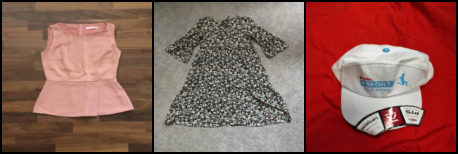

In [60]:
# --- Verification Cell ---
# Set seed for reproducibility of random sampling within the dataset
random.seed(42)

# Create a copy of the validation dataset to use as a base for the toy triplet dataset
toy_dataset_base = copy.deepcopy(validation_dataset)

# Apply a simple transformation
toy_dataset_base.transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Instantiate the TripleDataset using the prepared base dataset
triple_dataset_toy = TripleDataset(dataset=toy_dataset_base)

# Retrieve the first triplet (index 0) from the dataset
anchor_img, positive_image, negative_image = triple_dataset_toy[0]

# Display the triplet
images_list = [anchor_img, positive_image, negative_image]
grid = vutils.make_grid(images_list, nrow=3, padding=2) # nrow=3 ensures side-by-side display
grid_pil = transforms.ToPILImage()(grid)
print("Sample Triplet (Anchor, Positive, Negative):")
display(grid_pil)

**Expected Output:**

**Anchor**, **Positive (same class)**, **Negative (different class)**

<img src="./nb_images/anchor.png" width="150"/> <img src="./nb_images/positive.png" width="150"/> <img src="./nb_images/negative.png" width="150"/>

In [61]:
# Test your code!
unittests.exercise_3(TripleDataset)

 All tests passed!


* Now that your `TripleDataset` class is defined and verified, create an instance using your main `train_dataset`. Then, wrap it in a DataLoader to handle batching and shuffling during the training of your Siamese network.

In [62]:
# Instantiate the TripleDataset using the main training dataset
triple_dataset = TripleDataset(train_dataset)

# Create a DataLoader for the TripleDataset
siamese_dataloader = torch.utils.data.DataLoader(
    triple_dataset,
    batch_size=32,  # Define the number of triplets per batch
    shuffle=True,
)

---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-advanced-architectures-and-deployment/562).

---

<a name='2-3'></a>
### 2.3 - Architecting the Visual Search Model

With your `TripleDataset` ready to feed comparison examples, you can now build the Siamese Network itself. This architecture cleverly reuses the feature extraction capabilities you already built for the classifier, demonstrating the power of modular design.

<a name='2-3-1'></a>
#### 2.3.1 - The Siamese Encoder: Reusing the Backbone

The core of the Siamese Network is the **encoder**. This is the part that takes an image and converts it into a meaningful numerical representation (an embedding). Instead of building a new encoder from scratch, you'll leverage the `MobileNetBackbone` you created earlier. This is a prime example of **parameter sharing** and modularity in action – the backbone learns general visual features, which are useful for both classification and similarity tasks.

You'll wrap this backbone in a `SiameseEncoder` class. This wrapper adds a simple "representation head" consisting of an `AdaptiveAvgPool2d` layer followed by a `Flatten` layer. This head takes the 2D feature map produced by the backbone and converts it into a fixed size 1D vector – the final embedding.

* The `SiameseEncoder` class is defined below. Notice how it takes a `backbone` as input during initialization.

In [63]:
class SiameseEncoder(nn.Module):
    """
    Implements an encoder module suitable for Siamese networks.

    This class takes a pre-defined backbone (feature extractor) and adds a
    representation head (pooling + flatten) to produce a fixed-size vector
    embedding for an input image.
    """

    def __init__(self, backbone):
        """
        Initializes the SiameseEncoder.

        Args:
            backbone (nn.Module): The convolutional neural network to use
                                  as the feature extractor.
        """
        # Initialize the parent nn.Module
        super(SiameseEncoder, self).__init__()

        # Store the provided backbone model
        self.backbone = backbone

        # Define the representation head
        self.representation = nn.Sequential(
            # Apply adaptive average pooling to reduce spatial dimensions to 1x1
            # This makes the output size independent of the input image size (after backbone)
            nn.AdaptiveAvgPool2d(1),
            # Flatten the 1x1 feature map into a 1D vector
            nn.Flatten(),
        )

    def forward(self, x):
        """
        Defines the forward pass through the encoder.

        Args:
            x (torch.Tensor): The input tensor (e.g., a batch of images).

        Returns:
            torch.Tensor: The final 1D embedding vector for the input.
        """
        # 1. Extract features using the backbone
        features = self.backbone(x)
        # 2. Convert feature map to a fixed-size vector using the representation head
        representation = self.representation(features)
        # Return the resulting embedding vector
        return representation

* Instantiate the `SiameseEncoder`. You'll pass the backbone, `trained_classifier.backbone` *from your previously created `mobilenet_classifier`* to demonstrate reuse. This is efficient – the backbone's learned features are directly transferred.

In [64]:
# Create the Siamese Encoder instance
# Reuse the backbone from the classifier model you built earlier!
siamese_encoder = SiameseEncoder(
    backbone=trained_classifier.backbone # Pass the existing backbone
)

<a name='2-3-2'></a>
#### 2.3.2 - The Siamese Network Wrapper

Now you create the main `SiameseNetwork` class. This acts as a wrapper around your `siamese_encoder`. Its primary role during training is to take the three images of a triplet (anchor, positive, negative), pass *each* of them through the *same* `siamese_encoder` instance (ensuring shared weights), and return the three resulting embeddings. It also includes a `get_embedding` method, which is useful for processing single images during inference (when you want to find similar items).

* The `SiameseNetwork` class is defined below.

In [65]:
class SiameseNetwork(nn.Module):
    """
    Implements the main Siamese Network structure.

    This network takes multiple inputs (anchor, positive, negative during training)
    and processes each through a shared `embedding_network` (the SiameseEncoder)
    to produce corresponding embeddings.
    """

    def __init__(self, embedding_network):
        """
        Initializes the SiameseNetwork.

        Args:
            embedding_network (nn.Module): The shared encoder network (e.g., SiameseEncoder)
                                           that generates embeddings from images.
        """
        # Initialize the parent nn.Module
        super(SiameseNetwork, self).__init__()
        # Store the shared embedding network
        self.embedding_network = embedding_network

    def forward(self, anchor, positive, negative):
        """
        Defines the forward pass for training with image triplets.

        Args:
            anchor (torch.Tensor): The batch of anchor images.
            positive (torch.Tensor): The batch of positive images (same class as anchor).
            negative (torch.Tensor): The batch of negative images (different class from anchor).

        Returns:
            tuple: A tuple containing the embeddings for anchor, positive, and negative images.
                   (anchor_output, positive_output, negative_output)
        """
        # Process the anchor image through the embedding network
        anchor_output = self.embedding_network(anchor)
        # Process the positive image through the *same* embedding network (shared weights)
        positive_output = self.embedding_network(positive)
        # Process the negative image through the *same* embedding network (shared weights)
        negative_output = self.embedding_network(negative)

        # Return the generated embeddings
        return anchor_output, positive_output, negative_output

    def get_embedding(self, image):
        """
        Generates an embedding for a single input image. Used for inference/retrieval.

        Args:
            image (torch.Tensor): The input image tensor (should include batch dimension).

        Returns:
            torch.Tensor: The embedding vector for the image.
        """
        # Pass the single image through the embedding network
        return self.embedding_network(image)

* Instantiate the `SiameseNetwork`, passing the encoder you created.

In [66]:
# Instantiate the Siamese Network
siamese_network = SiameseNetwork(embedding_network=siamese_encoder)

<a name='2-4'></a>
### 2.4 - Training the Siamese Network

You have the data generator (`TripleDataset`) and the model architecture (`SiameseNetwork` wrapping the `SiameseEncoder`). Now, set up the final pieces needed for training:

* **Loss Function**: You'll use `nn.TripletMarginLoss`. This loss function directly implements the core idea of Siamese training: it calculates the distances between the anchor positive pair ($d(A, P)$) and the anchor negative pair ($d(A, N)$) and penalizes the model if $d(A, P)$ is not smaller than $d(A, N)$ by at least a specified `margin`. The goal is $d(A, P) + \text{margin} < d(A, N)$.

* **Optimizer**: `torch.optim.AdamW` is a good choice for optimizing the network's weights.

In [67]:
# EDITABLE CELL: Feel free to play around with different "margin" and "lr" values

# Define the Triplet Margin Loss function
# margin=1.0: Enforces that the negative sample should be at least 1.0 distance unit farther than the positive sample
# p=2.0: Use Euclidean distance (L2 norm)
loss_fcn = nn.TripletMarginLoss(margin=1.0, p=2.0)

# Define the AdamW optimizer, passing the Siamese network's parameters and a learning rate
optimizer = torch.optim.AdamW(siamese_network.parameters(), lr=0.001)

Now, train the Siamese network using the `siamese_training_loop` helper function. This loop focuses solely on minimizing the `TripletMarginLoss`. Unlike classification, the goal here isn't to achieve a specific accuracy during training, but rather to organize the embedding space effectively by pulling similar items (anchor, positive) closer and pushing dissimilar items (anchor, negative) apart. The decreasing loss value is your main indicator of progress. The true test of the model's success will be its performance in the visual search task later. Train for a small number of epochs initially to verify the setup.

In [68]:
# EDITABLE CELL:

# Define the number of training epochs
num_epochs = 5

In [69]:
# Run the training loop for the Siamese network
helper_utils.siamese_training_loop(
    # The Siamese model instance
    model=siamese_network,
    # The DataLoader providing triplets
    dataloader=siamese_dataloader,
    # The TripletMarginLoss function
    loss_fcn=loss_fcn,
    # The AdamW optimizer
    optimizer=optimizer,
    # The compute device
    device=device,
    # The number of epochs to train
    n_epochs=num_epochs,
)


--- Starting Siamese Training ---


Epoch 1/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/5 finished, Average Loss: 0.6766
    -> New best model saved (Epoch 1, Loss: 0.6766)


Epoch 2/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/5 finished, Average Loss: 0.6338
    -> New best model saved (Epoch 2, Loss: 0.6338)


Epoch 3/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/5 finished, Average Loss: 0.5635
    -> New best model saved (Epoch 3, Loss: 0.5635)


Epoch 4/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/5 finished, Average Loss: 0.5489
    -> New best model saved (Epoch 4, Loss: 0.5489)


Epoch 5/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/5 finished, Average Loss: 0.5470
    -> New best model saved (Epoch 5, Loss: 0.5470)

--- Siamese Training Complete ---
Loaded best model weights from Epoch 5 with lowest loss: 0.5470


<br>

**Remark:** Training for longer is necessary to achieve good performance. For the classifier, consider at least 15 epochs, and for the Siamese retrieval system, aim for at least 10 epochs. The short training here is just to demonstrate the process.

<a name='2-5'></a>
### 2.5 - Performing Visual Search (Retrieval)

With a trained Siamese network, you now have an encoder (`siamese_encoder`) capable of turning fashion images into meaningful embedding vectors. The final step is to use these embeddings to find similar items. This process typically involves:

1.  **Selecting a Query Image:** Choose an image for which you want to find similar items.
2.  **Generating Query Embedding:** Pass the query image through the trained `siamese_encoder` to get its embedding vector.
3.  **Generating Catalog Embeddings:** Process all images in your product catalog (represented here by the `validation_dataset`) through the `siamese_encoder` to create an embedding for each item. In a real system, these would be pre calculated and stored in a database for fast lookup.
4.  **Calculating Distances:** Compute the distance (e.g., Euclidean distance) between the query embedding and all catalog embeddings.
5.  **Ranking:** Sort the catalog items based on their distance to the query, from smallest (most similar) to largest (least similar).
6.  **Retrieving Top Results:** Select the top N items with the smallest distances.

#### Selecting the Query Image

You have two options for selecting the image you want to search for:

1.  **Use a Provided Sample Image:** You can use one of the sample images available in the `./images/` directory. Here are the paths:
    * `./images/dress.jpg`
    * `./images/hat.jpg`
    * `./images/longsleeve.jpg`
    * `./images/pant.jpg`
    * `./images/shoes.jpg`
    * `./images/shorts.jpg`
    * `./images/t_shirt.jpg`
>
2.  **Upload Your Own Image:** Use the widget below to upload a custom JPG image.
    * Running `helper_utils.upload_jpg_widget()` displays an upload widget.
    * You can only upload images with a `.jpg` extension.
    * Each image file size must not exceed 5 MB.
    * After successful upload, the widget will display the file path (e.g., `./uploads/your_image.jpg`). Copy this path.
    * You can reuse the widget multiple times without rerunning the cell.

* Run the cell below to display the image upload widget.

In [70]:
# Display the widget for uploading JPG images
helper_utils.upload_jpg_widget()

FileUpload(value=(), accept='.jpg,.jpeg', description='Upload JPG (Max 5MB)')

Output()

* Now, set the `image_path` variable below to the path of your chosen image (either one of the provided samples or the path displayed after uploading your own).

In [71]:
# EDITABLE CELL: Set the path for your query image

# Replace the example path below with the path to your desired query image
# Example using a provided image: image_path = './images/hat.jpg'
# Example using an uploaded image: image_path = './uploads/your_uploaded_image.jpg'

image_path = './images/t_shirt.jpg' ### Add your image path here

* Load and display your selected query image using the `get_query_img` helper function to confirm your choice.

Query Image:


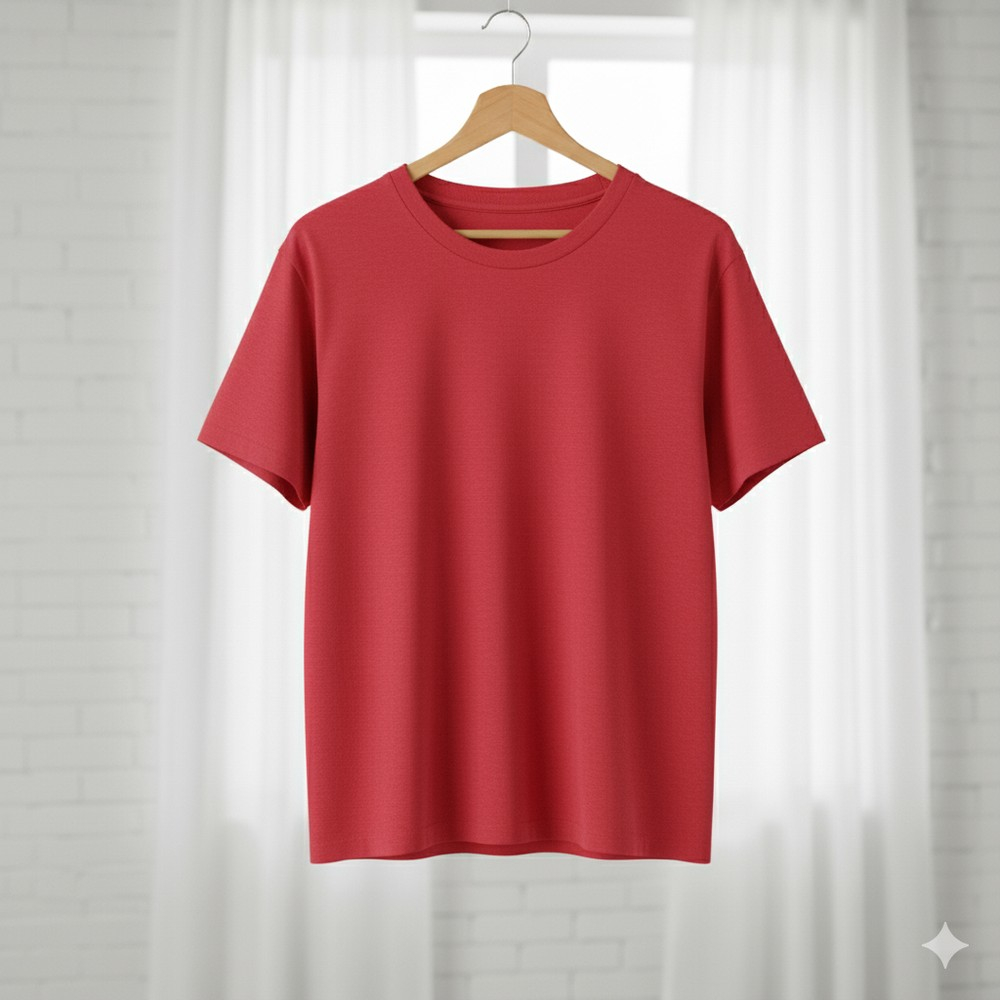

In [72]:
# Load the selected image using the helper function
query_img = helper_utils.get_query_img(image_path)
# Display the query image
print("Query Image:")
display(query_img)

* Define a function `get_query_img_embedding` to process a single PIL image: apply the necessary transformations, pass it through the trained encoder, and return its embedding as a NumPy array.

In [73]:
def get_query_img_embedding(encoder, transform, img, device):
    """
    Generates an embedding vector for a single query PIL image.

    Args:
        encoder (nn.Module): The trained embedding model (e.g., SiameseEncoder).
        transform (callable): The torchvision transforms to apply (e.g., resize, normalize).
        img (PIL.Image): The input query image.
        device (torch.device): The device ('cuda' or 'cpu') to perform inference on.

    Returns:
        np.ndarray: The embedding vector as a NumPy array.
    """
    # Apply the transformations (resize, ToTensor, normalize)
    tensor_img = transform(img)

    # Add a batch dimension (B, C, H, W) as the model expects batches
    # and move the tensor to the specified device
    query_img_tensor = tensor_img.unsqueeze(0).to(device)

    # Set the encoder to evaluation mode (important for layers like BatchNorm, Dropout)
    encoder.eval()
    # Perform inference without calculating gradients to save memory and computation
    with torch.no_grad():
        # Pass the image tensor through the encoder model
        query_img_embedding = encoder(query_img_tensor)

    # Move the resulting embedding tensor from the device (e.g., GPU) back to the CPU
    # and convert it into a NumPy array for easier handling (e.g., distance calculations)
    query_img_embedding_np = query_img_embedding.cpu().numpy()
    # Return the embedding as a NumPy array
    return query_img_embedding_np

* Generate the embedding for your `query_img` using the function you just defined and your trained `siamese_encoder`.

In [74]:
# Generate the embedding for the sample query image
query_img_embedding = get_query_img_embedding(siamese_encoder, val_transform, query_img, device)

# Print the shape of the resulting embedding vector (should be [1, embedding_dim])
print("Shape of query image embedding:", query_img_embedding.shape)

Shape of query image embedding: (1, 64)


* Now, generate embeddings for all images in your "catalog" (using the `validation_dataset` here as a stand in for a full product catalog). The `get_embeddings` helper function efficiently processes the entire dataset.

In [75]:
# Use the validation dataset as the "catalog" of items to search within
catalog = validation_dataset

# Use a helper function to efficiently generate embeddings for all items in the catalog
print("Generating embeddings for the catalog...")
embeddings = helper_utils.get_embeddings(siamese_encoder, catalog, device)
print(f"Generated {len(embeddings)} embeddings for the catalog.")

Generating embeddings for the catalog...
Generated 276 embeddings for the catalog.


#### Finding and Displaying Similar Items

* With embeddings generated for the query and the entire catalog, use the `find_closest` helper function to identify the indices of the `num_samples` most similar images in the catalog based on Euclidean distance.

In [76]:
# EDITABLE CELL: # Define how many similar items to retrieve

num_samples = 5

In [77]:
# Use a helper function to find the indices of the items in the catalog
# whose embeddings are closest (smallest Euclidean distance) to the query embedding
print(f"Finding the top {num_samples} closest items...")
closest_indices = helper_utils.find_closest(embeddings, query_img_embedding, num_samples)
print("Indices of closest items:", closest_indices)

Finding the top 5 closest items...
Indices of closest items: [212  22   4  99 203]


* Finally, retrieve the actual images and their labels from the catalog using the `closest_indices` and display them. These are the top visual matches for your query image according to your trained Siamese network!


Displaying the 5 most similar items found in the catalog:
Retrieved Item - Class: t-shirt (Index: 212)


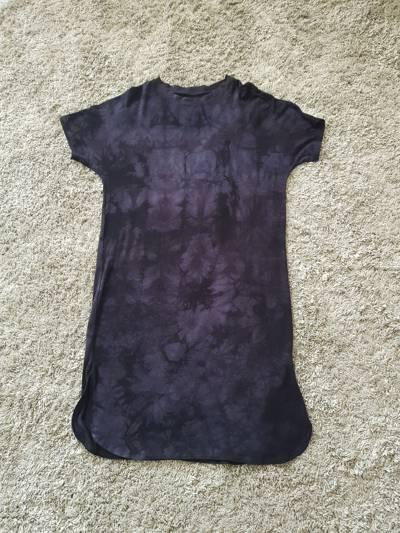

Retrieved Item - Class: dress (Index: 22)


In [ ]:
# Loop through the indices of the closest images found
print(f"\nDisplaying the {num_samples} most similar items found in the catalog:")
for idx_c in closest_indices:
    # Retrieve the image and its true label from the catalog dataset using the index
    # The helper function likely handles converting tensor back to displayable format
    img_c, label_idx_c = helper_utils.get_image(catalog, idx_c) # Assuming get_image returns PIL + label index
    label_c = catalog.classes[label_idx_c] # Get class name from index
    # Print the class label of the retrieved image
    print(f"Retrieved Item - Class: {label_c} (Index: {idx_c})")
    # Display the retrieved image
    display(img_c)

## Conclusion

Fantastic work completing this assignment and concluding Module 1! You've successfully applied advanced PyTorch concepts to build a sophisticated, dual-purpose AI system for a realistic e-commerce scenario. By acting as an AI engineer, you've moved beyond simple sequential models and embraced the power of custom, modular architectures.

You began by constructing an efficient classifier, mastering the implementation of the `InvertedResidualBlock` and assembling it into a `MobileNetBackbone`. Then, showcasing true engineering resourcefulness, you seamlessly repurposed that trained backbone to create a `SiameseEncoder`. You adeptly handled the shift to similarity learning by designing a `TripleDataset` and training a `SiameseNetwork` with `TripletMarginLoss`, effectively sculpting an embedding space where visual similarity translates to proximity. Finally, you brought it all together by implementing a practical visual search function, demonstrating how these embeddings can power features like product recommendations or "shop the look".

This assignment solidified key principles from the module: the importance of **modular design** for flexibility and reuse, the ability to implement **custom blocks** and architectures beyond simple sequences, and the distinct approaches required for **classification versus similarity learning**. The skills you've honed here, designing efficient blocks, reusing components, and adapting models for different objectives, are directly applicable to building state-of-the-art AI systems in many professional domains. Well done on building this intelligent fashion engine!